# Cloning quasars

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy
from scipy.interpolate import interp1d
import scipy.stats

I will take data from the redshift distributions of the quasars in the Sloan Digital Sky Survey

In [2]:
from astroML.datasets import fetch_dr7_quasar

# Fetch the quasar data
data = fetch_dr7_quasar()

# select the first 10000 points
data = data[:10000]

z = data['redshift']

C:\Users\loren\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\loren\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


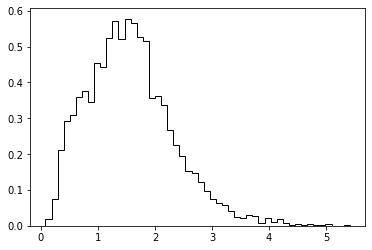

In [3]:
plt.hist(z, bins=50, histtype='step', color='black', density=True, label='original data');

Upsample this distribution in two ways, using both rejection sampling and inverse transform.

# Rejection sampling

I initially do an explicit method in order to visualize both accepted and rejected points.

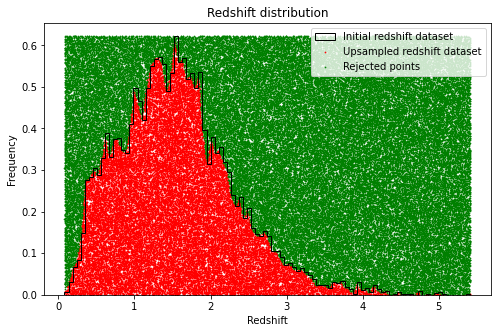

In [4]:
hist, bins = np.histogram(z, bins=100, density=True)

def unif_distrib(N):
    return np.random.uniform(low=min(bins), high=max(bins), size=N)

def rejection_sampling(N):
    x = unif_distrib(N)
    accepted_x = []
    accepted_y = []
    rejected_x = []
    rejected_y = []
    for i in x:   #i -> pointer for the x array 
        y_max = np.interp(i, bins[:-1], hist)
        j = np.random.uniform(0, max(hist)) #j -> pointer for the y array 
        if j < y_max:
            accepted_x.append(i)
            accepted_y.append(j)
        else:
            rejected_x.append(i)
            rejected_y.append(j)

    return np.array(accepted_x), np.array(accepted_y), np.array(rejected_x), np.array(rejected_y)

upsampled_x, upsampled_y, rej_x, rej_y = rejection_sampling(100000)

plt.figure(figsize=(8, 5))

plt.hist(z, bins=bins, density=True, histtype = 'step', color = 'black', label='Initial redshift dataset')

plt.scatter(upsampled_x, upsampled_y, color='red', marker = '.', s=2, alpha = 1, label='Upsampled redshift dataset')
plt.scatter(rej_x, rej_y, color='green', marker = '.', s=2, alpha = 1, label='Rejected points')

plt.title('Redshift distribution')
plt.xlabel('Redshift')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()

In this cell i use *scipy.stats.rv_histogram* to plot directly the histogram of the cloned data.

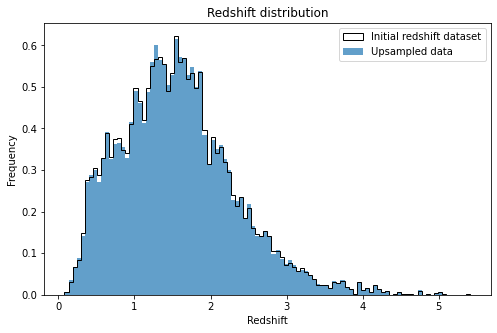

In [5]:
plt.figure(figsize=(8, 5))

plt.hist(z, bins=bins, density=True, histtype = 'step', color = 'black', label='Initial redshift dataset')
plt.hist((scipy.stats.rv_histogram((hist, bins))).rvs(size=100000), bins=bins, density=True, alpha=0.7, label='Upsampled data')

plt.title('Redshift distribution')
plt.xlabel('Redshift')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Inverse transform 

In [6]:
count, bins = np.histogram(z, bins=100, density=True)
bin_centers = (bins[:-1] + bins[1:]) / 2

pdf = count / sum(count) 

cdf = np.cumsum(count)
cdf /= cdf[-1] # normalization

def inverse_cdf(y):
    return np.interp(y, cdf, bin_centers)

x = np.random.uniform(0, 1, 100000)

upsampling = inverse_cdf(x)

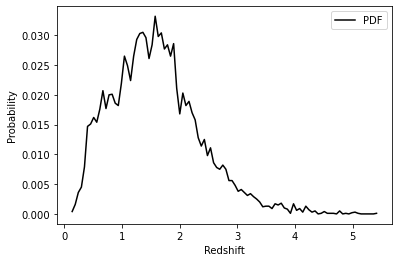

In [7]:
plt.plot(bins[1:], pdf, color='black', label="PDF")
plt.xlabel('Redshift')
plt.ylabel('Probability')
plt.legend()
plt.show()

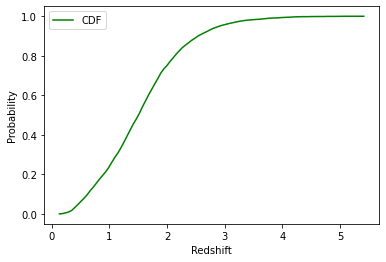

In [8]:
plt.plot(bins[1:], cdf, color='green', label="CDF")

plt.xlabel('Redshift')
plt.ylabel('Probability')
plt.legend()
plt.show()

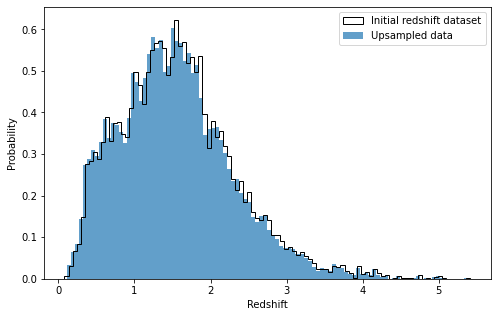

In [9]:
plt.figure(figsize=(8, 5))

plt.hist(z, bins=bins, density=True, histtype = 'step', color = 'black', label='Initial redshift dataset')
plt.hist(upsampling, bins=100, density=True, alpha=0.7, label='Upsampled data')

plt.xlabel('Redshift')
plt.ylabel('Probability')
plt.legend()
plt.show()

Let's try to assume that quasars are distributed uniformly in comoving volume in the Universe.

We use the cosmological parameters as measured by the Planck satellite, which is a flat $\Lambda$ CDM model.

In [98]:
astropy.cosmology.Planck18

FlatLambdaCDM(name="Planck18", H0=67.7 km / (Mpc s), Om0=0.31, Tcmb0=2.725 K, Neff=3.05, m_nu=[0.   0.   0.06] eV, Ob0=0.049)

In [19]:
class uniformredshift(object):
    def __init__(self,zmax):
        ''' Lazy loading...'''
        self._norm = None
        self._pdfmax = None
        self.zmax=zmax

    def _eval(self,z_vals):
        '''Unnormalized pdf'''
        return ((4.*np.pi*astropy.cosmology.Planck18.differential_comoving_volume(z_vals).value))


    def norm(self):
        '''Compute normalization'''
        if self._norm is None:
            self._norm = scipy.integrate.quad( self._eval, 0, self.zmax)[0]
        return self._norm


    def eval(self,z_vals):
        return self._eval(z_vals)/self.norm()

        return np.array(zsample)

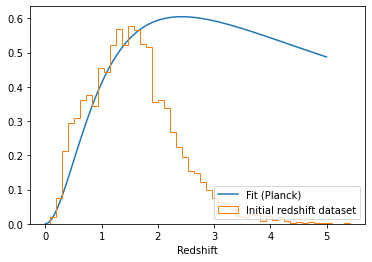

In [23]:
redshiftpdf = uniformredshift(zmax = 5)

redshifts = np.linspace(0,5,100)

plt.plot(redshifts,2.4*redshiftpdf.eval(redshifts), label='Fit (Planck)') ###   Arbitrary normalization, just matching by eye
plt.hist(z, bins=50, histtype='step',density=True, label='Initial redshift dataset')
plt.xlabel('Redshift')
plt.legend();

Are all quasars created equally? But do we see them equally?

Actually, not all quasars are created equally and we do not see them equally neither. The reason behind this could be the cosmic expansion and their light dimming (they appear less brigther if the distance increases).